In [1]:
# standard imports
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# own imports
import sys
sys.path.append("../../ml-library/")

from layers import GaussianSample
from models import VariationalAutoencoder

In [3]:
# set device
if torch.cuda.is_available():
    device = "cuda:0"
    torch.cuda.empty_cache()
else: 
    device = "cpu"

print(f"Using device {device}")

Using device cuda:0


# Get Data

In [4]:
# Get data
from data import get_mnist
train, _ = get_mnist(batch_size=64)

9920512it [00:01, 7532075.98it/s]                            
Extracting ./MNIST\MNIST\raw\train-images-idx3-ubyte.gz to ./MNIST\MNIST\raw
0it [00:00, ?it/s]Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz to ./MNIST\MNIST\raw\train-labels-idx1-ubyte.gz
32768it [00:00, 106796.23it/s]           
0it [00:00, ?it/s]Extracting ./MNIST\MNIST\raw\train-labels-idx1-ubyte.gz to ./MNIST\MNIST\raw
1654784it [00:00, 2008226.91it/s]                            
0it [00:00, ?it/s]Extracting ./MNIST\MNIST\raw\t10k-images-idx3-ubyte.gz to ./MNIST\MNIST\raw
8192it [00:00, 37051.05it/s]            
C:\Users\sap98\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torchvision\datasets\mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want

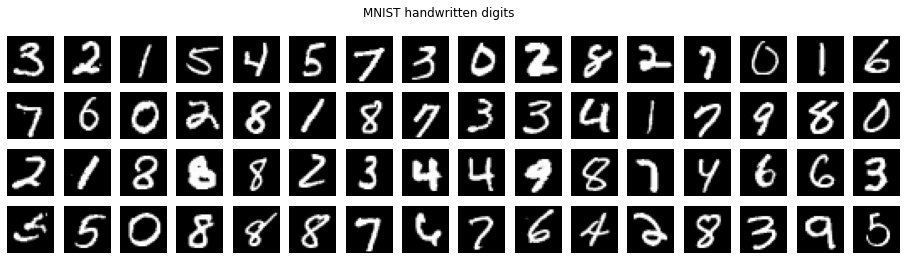

In [5]:
#plot a few MNIST examples
f, axarr = plt.subplots(4, 16, figsize=(16, 4))

# Load a batch of images into memory
images, labels = next(iter(train))

for i, ax in enumerate(axarr.flat):
    ax.imshow(images[i].view(28, 28), cmap="binary_r")
    ax.axis('off')
    
plt.suptitle('MNIST handwritten digits')
plt.show()

# Define Model

In [6]:
# Model Parameters
x_dim   = 784
z_dim   = 32
h_dims  = [512, 256]

In [7]:
# define model
model = VariationalAutoencoder([x_dim, z_dim, h_dims], as_beta=True)
model.to(device)
model

../../ml-library\models\vae.py:144: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  init.xavier_normal(m.weight.data)


VariationalAutoencoder(
  (encoder): Encoder(
    (hidden): ModuleList(
      (0): Linear(in_features=784, out_features=512, bias=True)
      (1): Linear(in_features=512, out_features=256, bias=True)
    )
    (sample): GaussianSample(
      (mu): Linear(in_features=256, out_features=32, bias=True)
      (log_var): Linear(in_features=256, out_features=32, bias=True)
    )
  )
  (decoder): BetaDecoder(
    (hidden): Sequential(
      (0): Linear(in_features=32, out_features=256, bias=True)
      (1): Tanh()
      (2): Linear(in_features=256, out_features=512, bias=True)
      (3): Tanh()
    )
    (reconstruction): Linear(in_features=512, out_features=784, bias=True)
    (activation): Sigmoid()
  )
)

# Train Model

In [8]:
# Define Optimizer
optimizer = torch.optim.Adagrad(model.parameters(), lr=1e-2)

# This is the β-VAE
from itertools import repeat
beta = repeat(4.0)

# import loss function
from losses import bce_loss

In [ ]:
from torch.autograd import Variable

# Training loop
for epoch in range(250):
    model.train()
    total_loss = 0
    for u, _ in iter(train):
        u = Variable(u.float()).to(device)

        reconstruction = model(u)
        
        likelihood = -bce_loss(reconstruction, u)
        elbo = likelihood - next(beta) * model.kld
        
        L = -torch.mean(elbo).to(device)

        L.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += L.data

    m = len(train)

    if epoch % 1 == 0:
        print(f"Epoch: {epoch}\tL: {total_loss/m:.2f}")

# Sample (MNIST)

In [ ]:
model.eval()
z_prior = Variable(torch.randn(16, 32)).to(device)

x_mu = model.sample(z_prior)

# plot
f, axarr = plt.subplots(4, 4, figsize=(18, 12))
samples = x_mu.data.view(-1, 28, 28).cpu().numpy()

for i, ax in enumerate(axarr.flat):
    ax.imshow(samples[i])
    ax.axis("off")

# Sample (SPRITE)

In [ ]:
x, *_ = next(iter(train))

In [ ]:
# Above image encoded to z
z, _, _ = model.encoder(Variable(x.float()).to(device))
z = z.repeat(10, 1)

# Perturb the first dimension of the first element
# the second dimension of the second element, etc.
for i in range(1, 10):
    z[i, i-1] += 10

samples = model.sample(z)

In [ ]:
f, axarr = plt.subplots(1, 10, figsize=(18, 3))

for i, ax in enumerate(axarr.flat):
    ax.set_title("Perturb axis {}".format(i))
    if i == 0:
        ax.set_title("Original")
    ax.imshow(samples[i].view(64, 64).data.cpu().numpy())
    ax.axis("off")
    
plt.suptitle("Generated samples from the model", fontsize=16)
plt.show()